# Building an OCR from scratch

So in this tutorial, I will give you a basic code walkthrough for building a simple OCR. OCR as might know stands for optical character recognition or in layman terms it means text recognition. Text recognition is one of the classic problems in computer vision and is still relevant today. One of the most important applications of text recognition is the digitization of old manuscripts. Physical copies of books and manuscripts are prone to degradations. With time, the printed characters start to fade. On simple way to preserve such documents is to make a digital copy of it and store it in the cloud or local hard drive which would ensure their continuance. Similarly, text recognition can also be used for licence plate recognition and can also be used in forensics in terms of handwriting recognition. 

Okay, now that I have given you enough motivation as to why OCR is important, let me show you how you can build one. 
So first things first, I'll start with listing down some of the essential packages that you would need to build your first OCR. We will be working with PyTorch as it is one of the most efficient deep learning libraries present. The other packages are as follows:

* Pytorch 1.5
* Matplotlib
* Tqdm
* textdistance
* lmdb

You can install them either via a pip or conda. I will also be providing a requirements.txt file which you can find in my Github repo. Do a simple `pip install -r requirements` and you are set to go.

## Setting up the Data

We will start our project by importing the libraries. But before that we need data. Now, you are free to use any text image data you might like and for that, you might need to build your own data loader. However, in the interest of keeping things simple, we will be using a neat little package called `trdg`, which is a synthetic image generator for OCR. You can find all the relevant information regarding this package on its [github repository](https://github.com/Belval/TextRecognitionDataGenerator). You can generate printed as well as hand-written text images and infuse them with different kinds of noise and degradation. In this project, I have used trdg to generate printed word images of a single font. You can use any font you like. Just download a `.ttf` file for your font and while generating the word images be sure to specify the `-ft` parameter as your font file. 

You can generate the word images for training using the following commands:

`trdg -i words.txt -c 20000 --output_dir data/train -ft your/fontfile`

Here, `-c` refers to the number of word images you want to generate. `words.txt` file contains our input word vocabulary while `--output_dir` and `-ft` refer to the output and font file respectively. You can similarly generate the test word images for evaluating the performance of your OCR. However, ensure that words for training and testing are mutually exclusive to each other.


Okay, now that we have generated the word images, let us display a few images using matlplotlib
%# TODO diplay images from folder

Now lets start importing the libraries that we would need to build our OCR

In [1]:
import os
import sys
import pdb
import six
import random
import lmdb
from PIL import Image
import numpy as np
import math
from collections import OrderedDict
from itertools import chain
import logging


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import sampler
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import random_split
sys.path.insert(0, '../')
from src.utils.utils import AverageMeter, Eval, OCRLabelConverter
from src.utils.utils import EarlyStopping, gmkdir
from src.optim.optimizer import STLR
from src.utils.utils import gaussian
from tqdm import *


Next, let us create our data pipe-line. We do this by inheriting the PyTorch Dataset class. The Dataset class has few methods that we need to adhere to like the `__len__` and `__getitem__` method. The `__len__` method returns the number of items in our dataset while `__getitem_` returns the data item for the index passed. You can find more information on PyTorch Dataset class on PyTorch's official documentation page. 

You will observe that we first convert each image into grayscale and convert it into a tensor. This is followed by normalizing the images so that our input data lies within a range of [-1, 1]. We pass all such transformations into a list and later call the transforms to compose function provided by PyTorch. The transform Compose function applies each transformation in the pre-defined order.

In [2]:
class SynthDataset(Dataset):
    def __init__(self, opt):
        super(SynthDataset, self).__init__()
        self.path = os.path.join(opt['path'], opt['imgdir'])
        self.images = os.listdir(self.path)
        self.nSamples = len(self.images)
        f = lambda x: os.path.join(self.path, x)
        self.imagepaths = list(map(f, self.images))
        transform_list = [transforms.Grayscale(1),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,))]
        self.transform = transforms.Compose(transform_list)
        self.collate_fn = SynthCollator()

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        imagepath = self.imagepaths[index]

        # Check if imagepath is a file and has a valid image file extension
        if os.path.isfile(imagepath) and imagepath.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            imagefile = os.path.basename(imagepath)
            img = Image.open(imagepath)
            if self.transform is not None:
                img = self.transform(img)
            item = {'img': img, 'idx': index}
            item['label'] = imagefile.split('_')[0]
            return item
        else:
            # Handle the case where imagepath is a directory or an unsupported file
            # You can log a warning or raise an exception as needed
            # For example, you can skip this item or return None
            return None

Next, since we are going to train our model using the mini-batch gradient descent, it is essential that each image in the batch is of the same shape and size. For this, we have defined the `SynthCollator` class which initially finds the image with maximum width in the batch and then proceeds to pad all images to have the same width. 

In [3]:
class LicensePlateDataset(SynthDataset):
    def __init__(self, opt, data_type='train'):
        super(LicensePlateDataset, self).__init__(opt)
        self.data_type = data_type
        self.plate_images = self.load_plate_images(data_type)

    def load_plate_images(self, data_type):
        plate_images = []
        plate_path = os.path.join(self.path, "plates", data_type)
        for plate_file in os.listdir(plate_path):
            plate_image_path = os.path.join(plate_path, plate_file)
            plate_images.append(plate_image_path)
        return plate_images

    def __getitem__(self, index):
        # Check if index corresponds to a license plate image
        if index < len(self.plate_images):
            plate_image_path = self.plate_images[index]
            plate_img = Image.open(plate_image_path)
            if self.transform is not None:
                plate_img = self.transform(plate_img)
            item = {'img': plate_img, 'idx': index}
            # For license plate dataset, you might want to include additional information like plate ID
            # You can extract this information from the plate_image_path or provide it in the labels.
            item['label'] = "LICENSE_PLATE_ID"
            return item
        else:
            # Handle other cases or use the parent class SynthDataset for words and characters
            return super(LicensePlateDataset, self).__getitem__(index)


In [4]:
class SynthCollator(object):
    def __init__(self, data_type='train'):
        self.data_type = data_type

    def __call__(self, batch):
        # Filter out None items
        batch = [item for item in batch if item is not None]

        if not batch:
            return None

        width = [item['img'].shape[2] for item in batch]
        indexes = [item['idx'] for item in batch]
        imgs = torch.ones([len(batch), batch[0]['img'].shape[0], batch[0]['img'].shape[1], max(width)], dtype=torch.float32)
        for idx, item in enumerate(batch):
            try:
                imgs[idx, :, :, 0:item['img'].shape[2]] = item['img']
            except:
                print(imgs.shape)

        item = {'img': imgs, 'idx': indexes}

        if 'label' in batch[0].keys():
            labels = [item['label'] for item in batch]
            item['label'] = labels

        # For license plate dataset, you may want to add additional processing here

        return item


## Defining our Model

Now we proceed to define our model. We use the CNN-LSTM based architecture which was proposed by Shi et.al. in their excellent paper [An End-to-End Trainable Neural Network for Image-based Sequence Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). The authors used it for scene-text recognition and showed via extensive experimentation that they were able to achieve significant gains in accuracy compared to all other existing methods at that time.


<img src="images/crnn.png" alt="drawing" width="400"/>

The figure above shows the architecture used in the paper. The authors used a 7 layered Convolution network with BatchNorm and ReLU. This was followed by a stacked RNN network consisting of two Bidirectional LSTM layers. The convolution layers acted as a feature extractor while the LSTMs layers act as sequence classifiers. The LSTM layers output the probability associated with each output class at each time step
Further details can be found in their paper and I strongly suggest you go through it for a better understanding.

The below code snippet is taken from this [github repository](https://github.com/meijieru/crnn.pytorch) which provides a Pytorch implementation of their code.


In [5]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    def forward(self, input):
        self.rnn.flatten_parameters()
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)
        return output

class CRNN(nn.Module):

    def __init__(self, opt, leakyRelu=False):
        super(CRNN, self).__init__()

        assert opt['imgH'] % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = opt['nChannels'] if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16
        self.cnn = cnn
        self.rnn = nn.Sequential()
        self.rnn = nn.Sequential(
            BidirectionalLSTM(opt['nHidden']*2, opt['nHidden'], opt['nHidden']),
            BidirectionalLSTM(opt['nHidden'], opt['nHidden'], opt['nClasses']))


    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)
        output = output.transpose(1,0) #Tbh to bth
        return output

## The CTC Loss 

Okay, now that we have our data and model pipeline ready, it is time to define our loss function which in our case is the CTC loss function. We will be using PyTorch's excellent CTC implementation. CTC stands for Connectionist Temporal Classification and was proposed by Alex Graves in his paper [Connectionist Temporal Classification: Labelling Unsegmented Sequence Data with Recurrent Neural Networks](https://www.cs.toronto.edu/~graves/icml_2006.pdf). 

Honestly, the above work has been a gamechanger for many sequences based tasks like speech and text recognition. For all the sequence-based tasks it is important for the input and output labels to be properly aligned. Proper alignment leads to efficient loss computation between the network predictions and expected output. In segmentation based approaches i.e. when the input word or line has been segmented into its constituent characters, there exists a direct one-to-one mapping between the segmented images of characters and the output labels.  However, as you might imagine obtaining such segmentations for each character can be a very tedious and time-consuming task. Thus, CTC based transcription layers have become the de-facto choice for OCRs and speech recognition module since it allows loss computation without explicit mapping between the input and output. The CTC layer takes the output from the LSTMs and computes a score with all possible alignments of the target label. The OCR is then trained to predict a sequence which maximizes the sum of all such scores.

If you want more thorough details regarding the CTC layer I would suggest you go through the following blogs and lecture video

* [CMU Deep Learning Course Lecture 14](https://www.youtube.com/watch?v=c86gfVGcvh4&t=670s)
* [Sequence Labelling with CTC](https://distill.pub/2017/ctc)

In [6]:
class CustomCTCLoss(torch.nn.Module):
    # T x B x H => Softmax on dimension 2
    def __init__(self, dim=2):
        super().__init__()
        self.dim = dim
        self.ctc_loss = torch.nn.CTCLoss(reduction='mean', zero_infinity=True)

    def forward(self, logits, labels,
            prediction_sizes, target_sizes):
        EPS = 1e-7
        loss = self.ctc_loss(logits, labels, prediction_sizes, target_sizes)
        loss = self.sanitize(loss)
        return self.debug(loss, logits, labels, prediction_sizes, target_sizes)
    
    def sanitize(self, loss):
        EPS = 1e-7
        if abs(loss.item() - float('inf')) < EPS:
            return torch.zeros_like(loss)
        if math.isnan(loss.item()):
            return torch.zeros_like(loss)
        return loss

    def debug(self, loss, logits, labels,
            prediction_sizes, target_sizes):
        if math.isnan(loss.item()):
            print("Loss:", loss)
            print("logits:", logits)
            print("labels:", labels)
            print("prediction_sizes:", prediction_sizes)
            print("target_sizes:", target_sizes)
            raise Exception("NaN loss obtained. But why?")
        return loss

## The Training Loop

The above code snippet builds a wrapper around pytorch's CTC loss function. Basically, what it does is that it computes the loss and passes it through an additional method called `debug`, which checks for instances when the loss becomes Nan. 

Shout out to [Jerin Philip](https://jerinphilip.github.io/) for this code.

Now, let us come to the training loop. The below code might look a bit cumbersome but it provides a nice abstraction which is quite intuitive and easy to use. The below code is based on [pytorch lighning](https://github.com/PyTorchLightning/pytorch-lightning)'s bolier plate template with few modifications of my own. :P

I will give a basic overview of what it does. Feel free to inspect each method using python debugger. So, the `OCRTrainer` class takes in the training and validation data. It also takes in the loss function, optimizer and the number of epoch it needs to train the model. The train and validation loader method returns the data loader for the train and validation data. the `run_batch` method does one forward pass for a batch of image-label pairs. It returns the loss as well as the character and word accuracy. Next, we have the step functions which does the backpropagation, calculates the gradient and updates the parameters for each batch of data. Besides we also have the `training_end` and `validation_end` methods that calculate the mean loss and accuracy for each batch after the completion of one single epoch

All, the methods defined are quite simple and I hope you will get the hang of it in no time.

In [7]:
class OCRTrainer(object):
    def __init__(self, opt):
        super(OCRTrainer, self).__init__()
        self.data_train = opt['data_train']
        self.data_val = opt['data_val']
        self.model = opt['model']
        self.criterion = opt['criterion']
        self.optimizer = opt['optimizer']
        self.schedule = opt['schedule']
        self.converter = OCRLabelConverter(opt['alphabet'])
        self.evaluator = Eval()
        print('Scheduling is {}'.format(self.schedule))
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=opt['epochs'])
        self.batch_size = opt['batch_size']
        self.count = opt['epoch']
        self.epochs = opt['epochs']
        self.cuda = opt['cuda']
        self.collate_fn = opt['collate_fn']
        self.init_meters()

    def init_meters(self):
        self.avgTrainLoss = AverageMeter("Train loss")
        self.avgTrainCharAccuracy = AverageMeter("Train Character Accuracy")
        self.avgTrainWordAccuracy = AverageMeter("Train Word Accuracy")
        self.avgValLoss = AverageMeter("Validation loss")
        self.avgValCharAccuracy = AverageMeter("Validation Character Accuracy")
        self.avgValWordAccuracy = AverageMeter("Validation Word Accuracy")

    def forward(self, x):
        logits = self.model(x)
        return logits.transpose(1, 0)

    def loss_fn(self, logits, targets, pred_sizes, target_sizes):
        loss = self.criterion(logits, targets, pred_sizes, target_sizes)
        return loss

    def step(self):
        self.max_grad_norm = 0.05
        clip_grad_norm_(self.model.parameters(), self.max_grad_norm)
        self.optimizer.step()
    
    def schedule_lr(self):
        if self.schedule:
            self.scheduler.step()

    def _run_batch(self, batch, report_accuracy=False, validation=False):
        input_, targets = batch['img'], batch['label']
        targets, lengths = self.converter.encode(targets)
        logits = self.forward(input_)
        logits = logits.contiguous().cpu()
        logits = torch.nn.functional.log_softmax(logits, 2)
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        targets= targets.view(-1).contiguous()
        loss = self.loss_fn(logits, targets, pred_sizes, lengths)
        if report_accuracy:
            probs, preds = logits.max(2)
            preds = preds.transpose(1, 0).contiguous().view(-1)
            sim_preds = self.converter.decode(preds.data, pred_sizes.data, raw=False)
            ca = np.mean((list(map(self.evaluator.char_accuracy, list(zip(sim_preds, batch['label']))))))
            wa = np.mean((list(map(self.evaluator.word_accuracy, list(zip(sim_preds, batch['label']))))))
        return loss, ca, wa

    def run_epoch(self, validation=False):
        if not validation:
            loader = self.train_dataloader()
            pbar = tqdm(loader, desc='Epoch: [%d]/[%d] Training'%(self.count, 
                self.epochs), leave=True)
            self.model.train()
        else:
            loader = self.val_dataloader()
            pbar = tqdm(loader, desc='Validating', leave=True)
            self.model.eval()
        outputs = []
        for batch_nb, batch in enumerate(pbar):
            if not validation:
                output = self.training_step(batch)
            else:
                output = self.validation_step(batch)
            pbar.set_postfix(output)
            outputs.append(output)
        self.schedule_lr()
        if not validation:
            result = self.train_end(outputs)
        else:
            result = self.validation_end(outputs)
        return result

    def training_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True)
        self.optimizer.zero_grad()
        loss.backward()
        self.step()
        output = OrderedDict({
            'loss': abs(loss.item()),
            'train_ca': ca.item(),
            'train_wa': wa.item()
            })
        return output

    def validation_step(self, batch):
        loss, ca, wa = self._run_batch(batch, report_accuracy=True, validation=True)
        output = OrderedDict({
            'val_loss': abs(loss.item()),
            'val_ca': ca.item(),
            'val_wa': wa.item()
            })
        return output

    def train_dataloader(self):
        # logging.info('training data loader called')
        loader = torch.utils.data.DataLoader(self.data_train,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=True)
        return loader
        
    def val_dataloader(self):
        # logging.info('val data loader called')
        loader = torch.utils.data.DataLoader(self.data_val,
                batch_size=self.batch_size,
                collate_fn=self.collate_fn)
        return loader

    def train_end(self, outputs):
        for output in outputs:
            self.avgTrainLoss.add(output['loss'])
            self.avgTrainCharAccuracy.add(output['train_ca'])
            self.avgTrainWordAccuracy.add(output['train_wa'])

        train_loss_mean = abs(self.avgTrainLoss.compute())
        train_ca_mean = self.avgTrainCharAccuracy.compute()
        train_wa_mean = self.avgTrainWordAccuracy.compute()

        result = {'train_loss': train_loss_mean, 'train_ca': train_ca_mean,
        'train_wa': train_wa_mean}
        # result = {'progress_bar': tqdm_dict, 'log': tqdm_dict, 'val_loss': train_loss_mean}
        return result

    def validation_end(self, outputs):
        for output in outputs:
            self.avgValLoss.add(output['val_loss'])
            self.avgValCharAccuracy.add(output['val_ca'])
            self.avgValWordAccuracy.add(output['val_wa'])

        val_loss_mean = abs(self.avgValLoss.compute())
        val_ca_mean = self.avgValCharAccuracy.compute()
        val_wa_mean = self.avgValWordAccuracy.compute()

        result = {'val_loss': val_loss_mean, 'val_ca': val_ca_mean,
        'val_wa': val_wa_mean}
        return result

## Putting Everything Together

And, finally, we have the `Learner` class. It implements a couple of more methods like the `save` and `load` model. It also tracks the losses and saves them in a `csv` file. This comes in handy if we want to analyze the behaviour of our training and validation loops. It initializes our `OCRTrainer` module with the necessary hyperparameters and later calls the `fit` method which runs the training loop.

Besides these methods, we have a bunch of helper methods like the `OCRLabel_converter`, `Eval` and `Averagemeter`. I am not including them in this notebook, instead, I have written them in utils.py file and I am importing them from there. In case you want to take a peek, feel free to tinker with the utils.py file. All the necessary documentation is provided in the file itself.

In [8]:
class Learner(object):
    def __init__(self, model, optimizer, savepath=None, resume=False):
        self.model = model
        self.optimizer = optimizer
        self.savepath = os.path.join(savepath, 'best.ckpt')
        self.cuda = torch.cuda.is_available() 
        self.cuda_count = torch.cuda.device_count()
        if self.cuda:
            self.model = self.model.cuda()
        self.epoch = 0
        if self.cuda_count > 1:
            print("Let's use", torch.cuda.device_count(), "GPUs!")
            self.model = nn.DataParallel(self.model)
        self.best_score = None
        if resume and os.path.exists(self.savepath):
            self.checkpoint = torch.load(self.savepath)
            self.epoch = self.checkpoint['epoch']
            self.best_score=self.checkpoint['best']
            self.load()
        else:
            print('checkpoint does not exist')

    def fit(self, opt):
        opt['cuda'] = self.cuda
        opt['model'] = self.model
        opt['optimizer'] = self.optimizer
        logging.basicConfig(filename="%s/%s.csv" %(opt['log_dir'], opt['name']), level=logging.INFO)
        self.saver = EarlyStopping(self.savepath, patience=15, verbose=True, best_score=self.best_score)
        opt['epoch'] = self.epoch
        trainer = OCRTrainer(opt)
        
        for epoch in range(opt['epoch'], opt['epochs']):
            train_result = trainer.run_epoch()
            val_result = trainer.run_epoch(validation=True)
            trainer.count = epoch
            info = '%d, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f'%(epoch, train_result['train_loss'], 
                val_result['val_loss'], train_result['train_ca'],  val_result['val_ca'],
                train_result['train_wa'], val_result['val_wa'])
            logging.info(info)
            self.val_loss = val_result['val_loss']
            print(self.val_loss)
            if self.savepath:
                self.save(epoch)
            if self.saver.early_stop:
                print("Early stopping")
                break

    def load(self):
        print('Loading checkpoint at {} trained for {} epochs'.format(self.savepath, self.checkpoint['epoch']))
        self.model.load_state_dict(self.checkpoint['state_dict'])
        if 'opt_state_dict' in self.checkpoint.keys():
            print('Loading optimizer')
            self.optimizer.load_state_dict(self.checkpoint['opt_state_dict'])

    def save(self, epoch):
        self.saver(self.val_loss, epoch, self.model, self.optimizer)

### Defining the hyperparameters

Okay, now that we have set the premise, its time to unfold the drama. We begin by defining our vocabulary i.e. the alphabets which serve as the output classes for our model.
We define a suitable name for this experiment which will also serve as the folder name where the checkpoints and log files will be stored. We also define the hyper-parameters like the batch size, learning rate, image height, number of channels etc.

Then we initialize our Dataset class and split the data into train and validation. We then proceed to initialize our Model and CTCLoss and finally call the `learner.fit` function.

Once the training is over we can find the saved model in the `checkpoints/name` folder. We may load the model and evaluate its performance on the test data or finetune it on some other data.

In [14]:
alphabet = """Only thewigsofrcvdampbkuq.$A-210xT5'MDL,RYHJ"ISPWENj&BC93VGFKz();#:!7U64Q8?+*ZX/%"""
args = {
    'name':'exp1',
    'path':'../plates_1',
    'imgdir': 'Train',
    'imgH':32,
    'nChannels':1,
    'nHidden':256,
    'nClasses':len(alphabet),
    'lr':0.001,
    'epochs':4,
    'batch_size':32,
    'save_dir':'../checkpoints/',
    'log_dir':'../logs',
    'resume':False,
    'cuda':False,
    'schedule':False
    
}

data = SynthDataset(args)
args['collate_fn'] = SynthCollator()
train_split = int(0.8*len(data))
val_split = len(data) - train_split
args['data_train'], args['data_val'] = random_split(data, (train_split, val_split))
print('Traininig Data Size:{}\nVal Data Size:{}'.format(
    len(args['data_train']), len(args['data_val'])))
args['alphabet'] = alphabet
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
savepath = os.path.join(args['save_dir'], args['name'])
gmkdir(savepath)
gmkdir(args['log_dir'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
learner = Learner(model, optimizer, savepath=savepath, resume=args['resume'])
learner.fit(args)

Traininig Data Size:133
Val Data Size:34
checkpoint does not exist
None
Scheduling is False


Epoch: [0]/[4] Training:   0%|          | 0/5 [00:00<?, ?it/s]

torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])
torch.Size([32, 1, 107, 657])


Epoch: [0]/[4] Training:   0%|          | 0/5 [00:07<?, ?it/s]


AssertionError: the height of conv must be 1

: 

## Evaluation and testing

In [68]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [71]:
def get_accuracy(args):
    # DataLoader for the test data
    loader = torch.utils.data.DataLoader(
        args['plates_1'],
        batch_size=args['batch_size'],
        collate_fn=args['collate_fn']
    )

    # Load the model
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = args['model'].to(device)
    model.eval()

    # Label converter
    converter = OCRLabelConverter(args['alphabet'])

    # Lists to store results
    labels, predictions, images = [], [], []

    for iteration, batch in enumerate(tqdm(loader)):
        input_, targets = batch['img'].to(device), batch['label']
        images.extend(input_.squeeze().detach().cpu().numpy())
        labels.extend(targets)
        targets, lengths = converter.encode(targets)
        logits = model(input_).transpose(1, 0)
        logits = torch.nn.functional.log_softmax(logits, 2)
        logits = logits.contiguous().cpu()
        T, B, H = logits.size()
        pred_sizes = torch.LongTensor([T for i in range(B)])
        probs, pos = logits.max(2)
        pos = pos.transpose(1, 0).contiguous().view(-1)
        sim_preds = converter.decode(pos.data, pred_sizes.data, raw=False)
        predictions.extend(sim_preds)

    # Visualize some results (you can comment this out later)
    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(10, 12))
    for i, ax in enumerate(axes.flat):
        img = images[i]
        ax.imshow(img.transpose(1, 2, 0))  # Assuming img is in CHW format
        ax.set_title(predictions[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    # Calculate car plates accuracy
    correct_predictions = sum(1 for p, l in zip(predictions, labels) if p == l)
    total_samples = len(predictions)

    if total_samples == 0:
        print("No data found in the test set.")
        return 0.0

    car_plate_accuracy = correct_predictions / total_samples
    return car_plate_accuracy


Loading model ../checkpoints_plates/exp1/best.ckpt


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


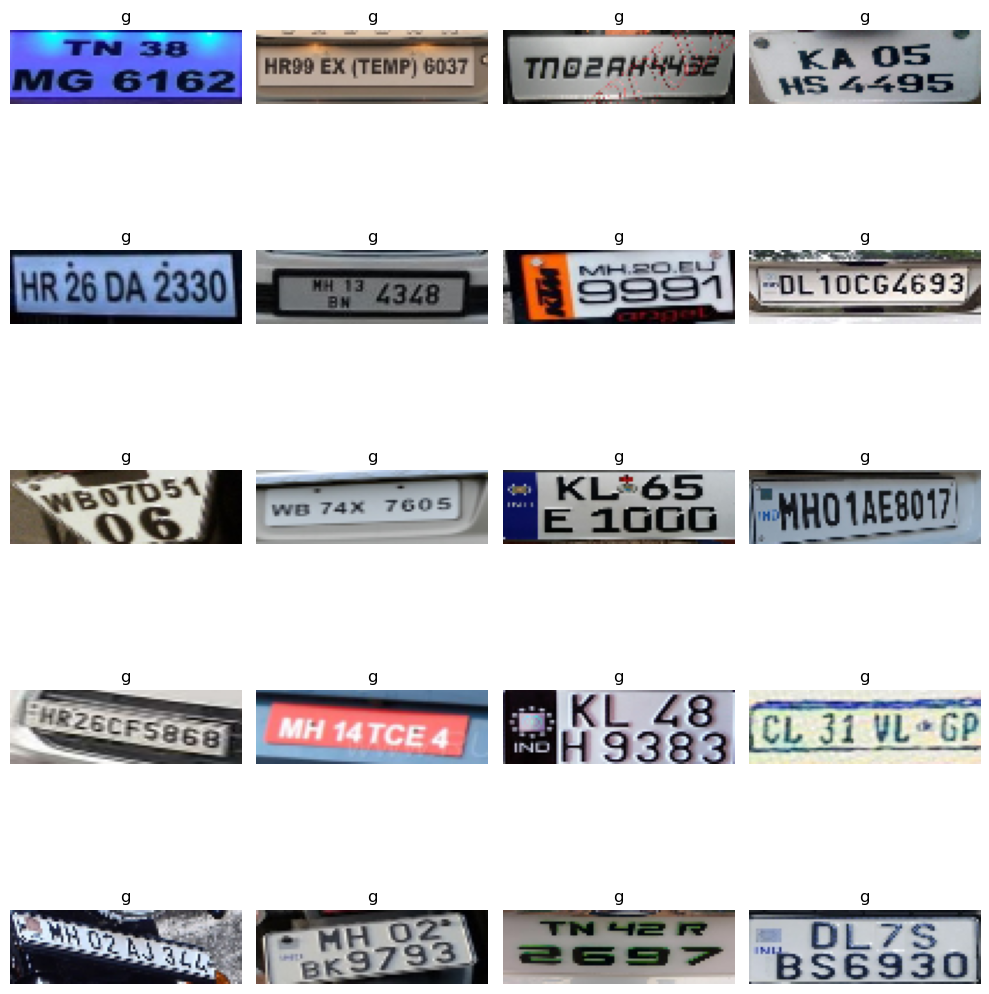

Car Plate Accuracy: 0.00


In [79]:
args['plates_1'] = CarPlateDataset(args)
args['collate_fn'] = CarPlateCollator(args['imgH'], args['imgW'])

# Initialize and load the model
model = CRNN(args)
args['criterion'] = CustomCTCLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

    # Check if the checkpoint file exists
resume_file = os.path.join(args['save_dir'], args['name'], 'best.ckpt')
torch.load(resume_file)
if os.path.isfile(resume_file):
    print('Loading model %s' % resume_file)
    checkpoint = torch.load(resume_file)
    model.load_state_dict(checkpoint['state_dict'])
    args['model'] = model
    car_plate_accuracy = get_accuracy(args)
    print("Car Plate Accuracy: %.2f" % car_plate_accuracy)
else:
    print("=> no checkpoint found at '{}'".format(os.path.join(args['save_dir'], args['name'])))
    print('Exiting')